In [23]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from models3D import upsample_vit_attention
from plotting_utils_torch import view_image_data

In [24]:
mask_path = "/home/diogommiranda/tese/masks/ROI_MASK.nii"
img = nib.load(mask_path)
volume = img.get_fdata(dtype=np.float32)
current_min = np.min(volume)
current_max = np.max(volume)
print(f"Calculated Min: {current_min}, Max: {current_max}")
volume = np.transpose(volume, (2, 1, 0)) # (D, H, W)
volume = np.expand_dims(volume, axis=0) # Add channel dimension
volume = np.expand_dims(volume, axis=0) # Add batch dimension
volume = torch.from_numpy(volume)
print(f"Shape after transpose: {volume.shape}")

Calculated Min: 0.0, Max: 1.0
Shape after transpose: torch.Size([1, 1, 91, 109, 91])


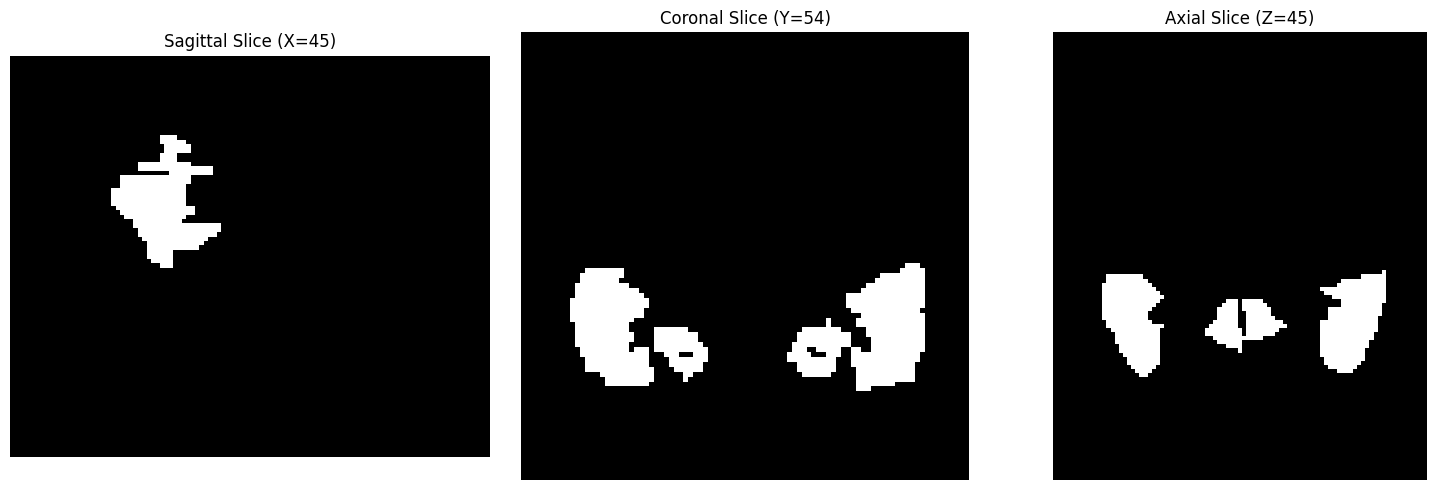

In [25]:
view_image_data(volume[0, 0, :, :, :])

In [30]:
# Get the number of voxels outside the mask
num_voxels_outside_mask = (volume == 0).sum().item()
print(f"Number of voxels outside the mask: {num_voxels_outside_mask}")
# Get the number of voxels inside the mask
num_voxels_inside_mask = (volume == 1).sum().item()
print(f"Number of voxels inside the mask: {num_voxels_inside_mask}")

# print the percentage of non-zero values in the volume
non_zero_percentage = (volume != 0).float().mean().item() * 100
print(f"Percentage of non-zero values: {non_zero_percentage:.2f}%")

Number of voxels outside the mask: 865245
Number of voxels inside the mask: 37384
Percentage of non-zero values: 4.14%


In [5]:
# compute the number of voxels in the volume and the number of non-zero voxels
num_voxels = volume.numel()
print(f"Number of voxels in the volume: {num_voxels}")
num_non_zero_voxels = (volume != 0).sum().item()
print(f"Number of non-zero voxels in the volume: {num_non_zero_voxels}")

Number of voxels in the volume: 902629
Number of non-zero voxels in the volume: 37384


In [6]:
roi_scores = F.interpolate(
    input = volume,
    mode = 'area',
    size = (6, 7, 6)
)
print(roi_scores.shape)
roi_scores = roi_scores.squeeze(0).squeeze(0)  # Remove batch and channel dimensions
print(roi_scores.shape)

torch.Size([1, 1, 6, 7, 6])
torch.Size([6, 7, 6])


In [7]:
roi_min = torch.min(roi_scores)
roi_max = torch.max(roi_scores)
print(f"ROI Min: {roi_min.item()}, ROI Max: {roi_max.item()}")

ROI Min: 0.0, ROI Max: 0.572021484375


In [8]:
token_roi_scores = roi_scores.flatten()
print(f"Token ROI Scores Shape: {token_roi_scores.shape}")

Token ROI Scores Shape: torch.Size([252])


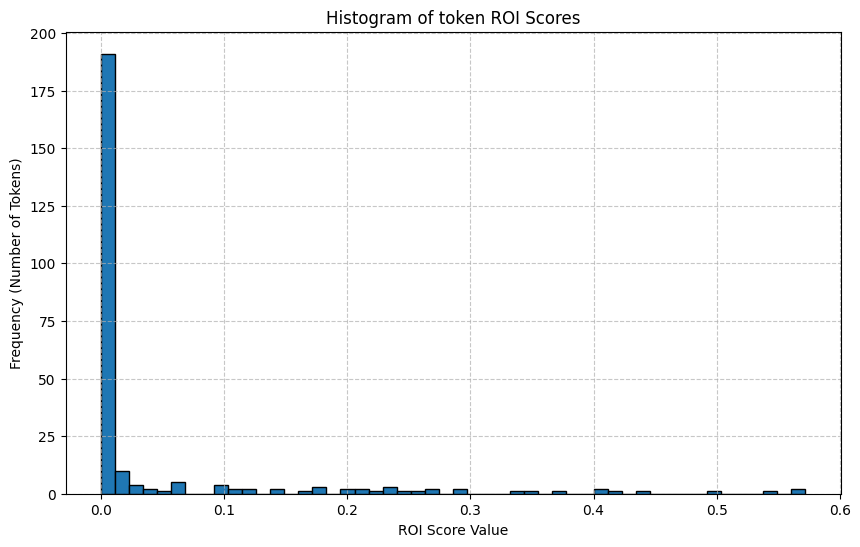

In [9]:
# 1. Histogram of Original Interpolated (but not yet softmaxed) Token ROI Scores
plt.figure(figsize=(10, 6))
plt.hist(token_roi_scores.cpu().numpy(), bins=50, edgecolor='black')
plt.title("Histogram of token ROI Scores")
plt.xlabel("ROI Score Value")
plt.ylabel("Frequency (Number of Tokens)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Note: 
- Only 81 tokens have non-zero scores
- Only 63 tokens have score greater than 0.01
- Only 45 tokens have score greater than 0.05
- Only 37 tokens have score greater than 0.1
- Only 11 tokens have score greater than 0.3

In [10]:
roi_list = token_roi_scores.tolist()
print(roi_list)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.017463235184550285, 0.005055147223174572, 0.0, 0.02366727963089943, 0.0, 0.0, 0.0185546875, 0.0029296875, 0.0029296875, 0.052978515625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013786765048280358, 0.0, 0.0, 0.01171875, 0.0004595588252414018, 0.0986328125, 0.262451171875, 0.01123046875, 0.0068359375, 0.251220703125, 0.12158203125, 0.13947610557079315, 0.5436580777168274, 0.2709099352359772, 0.2203584611415863, 0.5009191036224365, 0.23322610557079315, 0.019775390625, 0.21484375, 0.09423828125, 0.10498046875, 0.180419921875, 0.039794921875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10202205926179886, 0.0002297794126207009, 0.0002297794126207009, 0.1812959611415863, 0.008961397223174572, 0.230712890625, 0.572021484375, 0.20654296875, 0.20458984375, 0.565185546875, 0.2958984375, 

In [11]:
boolean = (token_roi_scores > 0.5)
len(boolean[boolean == True]) 
print(f"Number of tokens: {len(boolean[boolean == True])}/{len(boolean)}")

Number of tokens: 4/252


In [12]:
# get the indices of the tokens where boolean is True
indices = torch.where(boolean)[0]
print(f"Indices o: {indices}")

Indices o: tensor([ 61,  64,  97, 100])


In [13]:
# get the index of the token with the greatest score
max_score = torch.max(token_roi_scores)
indices = torch.where(token_roi_scores==max_score)[0]
print(f"Index of tokens with greatest score {max_score}: {indices.tolist()}")

Index of tokens with greatest score 0.572021484375: [97]


In [14]:
boolean[97]

tensor(True)


Softmax (T=1) Min: 0.003775653662160039, Max: 0.006689873989671469


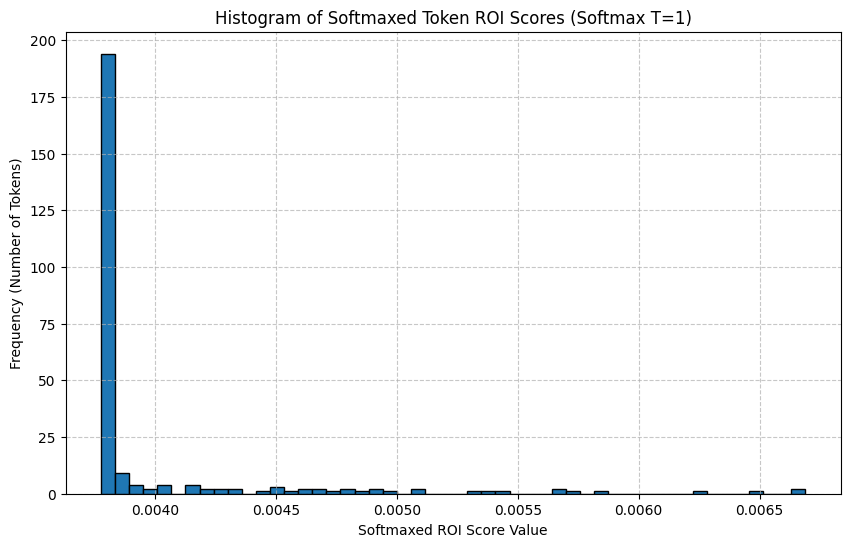

In [15]:
token_roi_scores_softmax = F.softmax(token_roi_scores, dim=0)
softmax_min_temp = torch.min(token_roi_scores_softmax)
softmax_max_temp = torch.max(token_roi_scores_softmax)
print(f"\nSoftmax (T={1}) Min: {softmax_min_temp.item()}, Max: {softmax_max_temp.item()}")

plt.figure(figsize=(10, 6))
plt.hist(token_roi_scores_softmax.cpu().numpy(), bins=50, edgecolor='black')
plt.title("Histogram of Softmaxed Token ROI Scores (Softmax T=1)")
plt.xlabel("Softmaxed ROI Score Value")
plt.ylabel("Frequency (Number of Tokens)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Softmax (T=0.5) Min: 0.0035357263404875994, Max: 0.011100184172391891


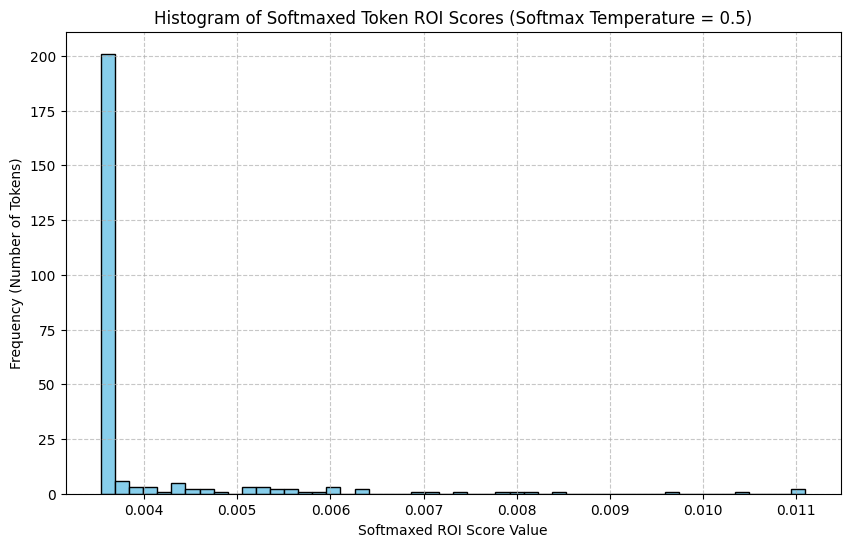


Softmax (T=0.1) Min: 0.0005645053461194038, Max: 0.1721574366092682


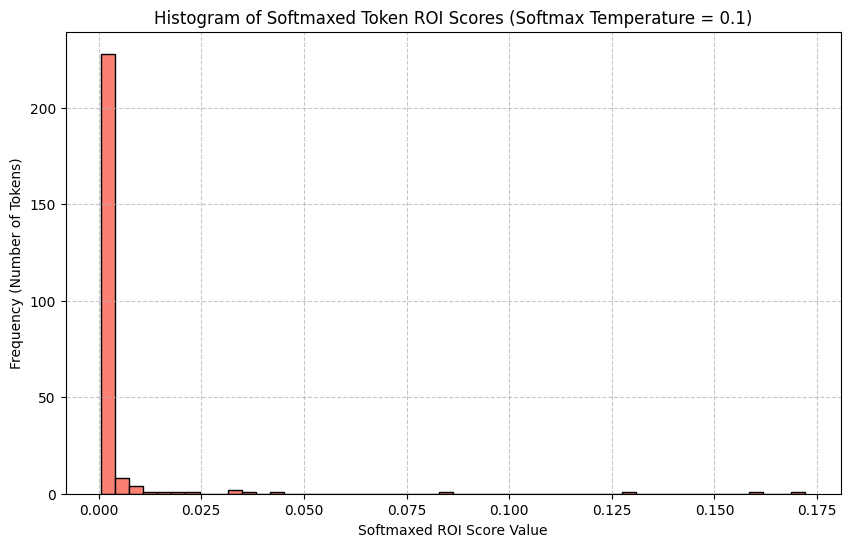

In [16]:
temperatures_to_try = [0.5, 0.1]

for T in temperatures_to_try:
    token_roi_scores_softmax = F.softmax(token_roi_scores / T, dim=0)
    softmax_min_temp = torch.min(token_roi_scores_softmax)
    softmax_max_temp = torch.max(token_roi_scores_softmax)
    print(f"\nSoftmax (T={T}) Min: {softmax_min_temp.item()}, Max: {softmax_max_temp.item()}")

    plt.figure(figsize=(10, 6))
    plt.hist(token_roi_scores_softmax.cpu().numpy(), bins=50, facecolor='skyblue' if T !=0.1 else 'salmon', edgecolor='black')
    plt.title(f"Histogram of Softmaxed Token ROI Scores (Softmax Temperature = {T})")
    plt.xlabel("Softmaxed ROI Score Value")
    plt.ylabel("Frequency (Number of Tokens)")
    plt.grid(True, linestyle='--', alpha=0.7)
    # You might want to adjust x-axis limits for very peaky distributions
    # plt.xlim([0, max(0.01, softmax_max_temp.item() * 1.1)]) # Example dynamic xlim
    plt.show()

# Square root transformed

In [17]:
# square root all token roi values
token_roi_scores_sq = torch.sqrt(token_roi_scores)

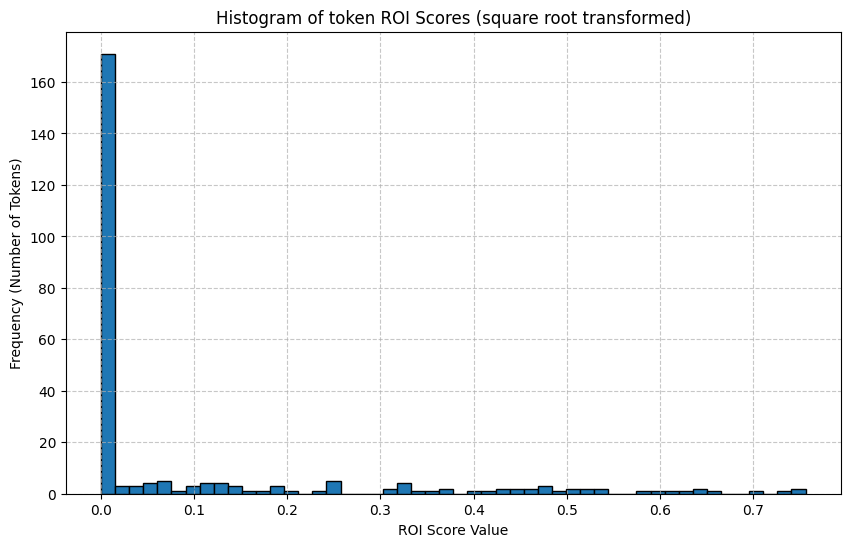

In [18]:
# 1. Histogram of Original Interpolated (but not yet softmaxed) Token ROI Scores
plt.figure(figsize=(10, 6))
plt.hist(token_roi_scores_sq.cpu().numpy(), bins=50, edgecolor='black')
plt.title("Histogram of token ROI Scores (square root transformed)")
plt.xlabel("ROI Score Value")
plt.ylabel("Frequency (Number of Tokens)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Note: 
- Only 81 tokens have non-zero scores
- Only 81 tokens have score greater than 0.01
- Only 74 tokens have score greater than 0.05
- Only 63 tokens have score greater than 0.1
- Only 39 tokens have score greater than 0.3
- Only 17 tokens have score greater than 0.5

In [19]:
boolean = (token_roi_scores_sq > 0.5)
len(boolean[boolean == True]) # Number of tokens with score > 0.025
print(f"Number of tokens with score > 0.1: {len(boolean[boolean == True])}/{len(boolean)}")

Number of tokens with score > 0.1: 17/252



Softmax (T=1) Min: 0.0035358972381800413, Max: 0.007532960269600153


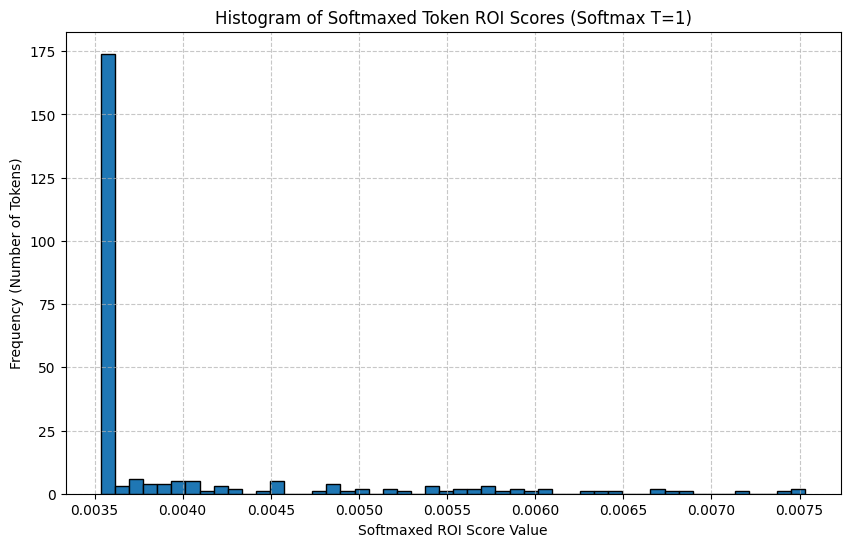

In [20]:
token_roi_scores_softmax = F.softmax(token_roi_scores_sq, dim=0)
softmax_min_temp = torch.min(token_roi_scores_softmax)
softmax_max_temp = torch.max(token_roi_scores_softmax)
print(f"\nSoftmax (T={1}) Min: {softmax_min_temp.item()}, Max: {softmax_max_temp.item()}")

plt.figure(figsize=(10, 6))
plt.hist(token_roi_scores_softmax.cpu().numpy(), bins=50, edgecolor='black')
plt.title("Histogram of Softmaxed Token ROI Scores (Softmax T=1)")
plt.xlabel("Softmaxed ROI Score Value")
plt.ylabel("Frequency (Number of Tokens)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


Softmax (T=0.8) Min: 0.003411700949072838, Max: 0.0087811928242445


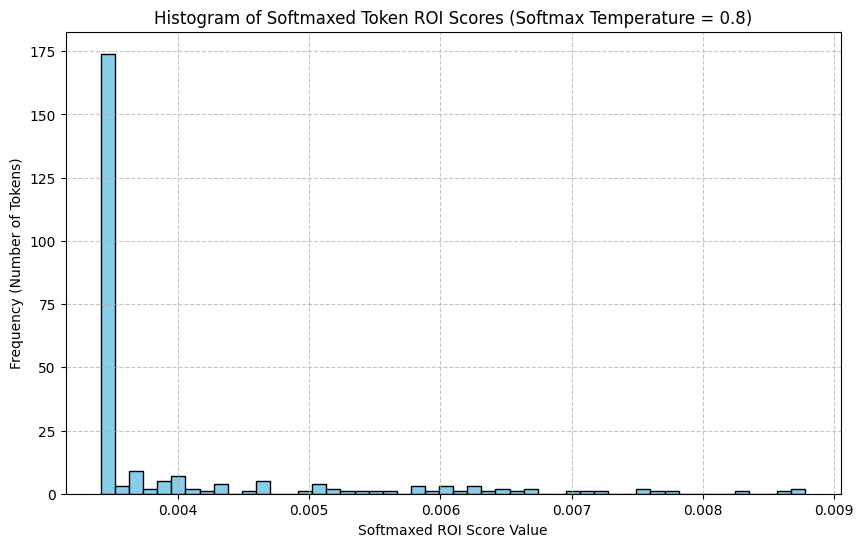


Softmax (T=0.5) Min: 0.00300311460159719, Max: 0.013630256056785583


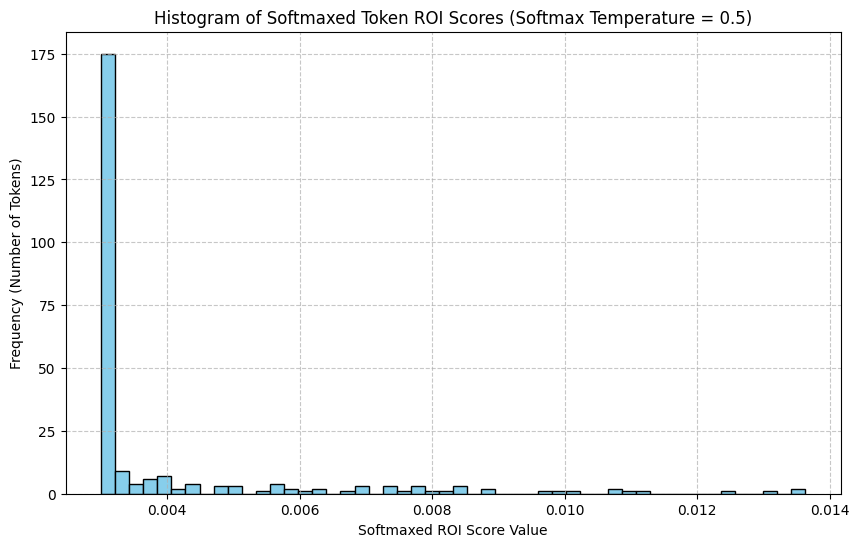

In [21]:
temperatures_to_try = [0.8, 0.5]

for T in temperatures_to_try:
    token_roi_scores_softmax = F.softmax(token_roi_scores_sq / T, dim=0)
    softmax_min_temp = torch.min(token_roi_scores_softmax)
    softmax_max_temp = torch.max(token_roi_scores_softmax)
    print(f"\nSoftmax (T={T}) Min: {softmax_min_temp.item()}, Max: {softmax_max_temp.item()}")

    plt.figure(figsize=(10, 6))
    plt.hist(token_roi_scores_softmax.cpu().numpy(), bins=50, facecolor='skyblue' if T !=0.1 else 'salmon', edgecolor='black')
    plt.title(f"Histogram of Softmaxed Token ROI Scores (Softmax Temperature = {T})")
    plt.xlabel("Softmaxed ROI Score Value")
    plt.ylabel("Frequency (Number of Tokens)")
    plt.grid(True, linestyle='--', alpha=0.7)
    # You might want to adjust x-axis limits for very peaky distributions
    # plt.xlim([0, max(0.01, softmax_max_temp.item() * 1.1)]) # Example dynamic xlim
    plt.show()

In [22]:
# check shapes with mock roi_list
att_cls = torch.tensor(roi_list, dtype=torch.float32)

att_volume = upsample_vit_attention(att_cls, (91, 109, 91), (6, 7, 6))
print(f"Attention Volume Shape: {att_volume.shape}")

Attention Volume Shape: torch.Size([91, 109, 91])
